# ARIMA on Olist Revenue

## 0. Imports

### 0.1. Libraries

In [1]:
# Data manipulation libraries
import pandas                               as pd
import numpy                                as np

# Data visualization libraries
import seaborn                              as sns
import matplotlib                           as mpl
import matplotlib.pyplot                    as plt

# Time series libraries
import statsmodels                          as sm

# Decomposition of time series
from statsmodels.tsa.seasonal               import seasonal_decompose
# ACF and PACF
from statsmodels.graphics.tsaplots          import plot_acf, plot_pacf
# Stationarity tests
from statsmodels.tsa.stattools              import adfuller, kpss
# Models
from pmdarima.arima                         import auto_arima
from statsmodels.tsa.arima.model            import ARIMA
from statsmodels.tsa.statespace.sarimax     import SARIMAX

# Metrics
from sklearn.metrics                        import mean_absolute_error, mean_squared_error

# Other libraries
import warnings

### 0.2. Settings

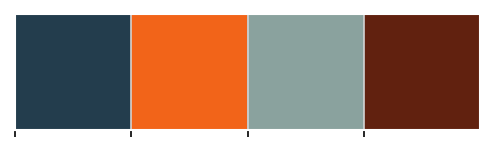

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

# Palette Seting
ts_palette = ['#233D4D', '#F26419', '#8AA29E', '#61210F']
kde_palette = ['#233D4D', '#61210F']

sns.set_palette(sns.color_palette(ts_palette))
sns.palplot(sns.color_palette(ts_palette))

# Random Seed
SEED = 42

### 0.3. Functions

In [3]:
def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame.

    Args:
        df: the DataFrame we want to know more about.
    
    Returns: a text indicating the number of rows and columns of the DataFrame.
    """

    print('Number of rows: {:,}'.format(df.shape[0]))
    print('Number of columns: {:,}'.format(df.shape[1]))

    return None

def set_image(fig, title, xlabel, ylabel):
    """
    Summary: 
        This function sets the image configuration

    Args:
        fig: the figure we want to set the configuration
        title: the title of the plot
        xlabel: the label for the x axis
        ylabel: the label for the y axis

    Returns: None
    """
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')
    fig.tick_params(left=False, bottom=False)

    return None

### 0.4. Data

In [4]:
# Importing price dataset
df_revenue = pd.read_csv('../../data/interim/arima_prices_dataset.csv')

## 1. Data Description

In [5]:
df_revenue.head()

,date,price
0,2017-02-01,8219.750
1,2017-02-02,8917.640
2,2017-02-03,10183.740
3,2017-02-04,13968.160
4,2017-02-05,8503.790


### 1.1. Shape

In [6]:
df_shape(df_revenue)

Number of rows: 560
Number of columns: 2


### 1.2. Transformations

In [7]:
# Setting 'date' as datetime
df_revenue['date'] = pd.to_datetime(df_revenue['date'])
# Setting 'date' as index
df_revenue.set_index('date', inplace=True)
# Setting frequency as daily
df_revenue = df_revenue.asfreq('D')
# Changing name of the column
df_revenue.rename(columns={'price':'revenue'}, inplace=True)

In [8]:
# Taking a look at the dataframe, we can see the dates as DatetimeIndex in daily frequency and prices as float64
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560 entries, 2017-02-01 to 2018-08-14
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  560 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


## 2. Visualization

### 2.1. Full visualization of the data

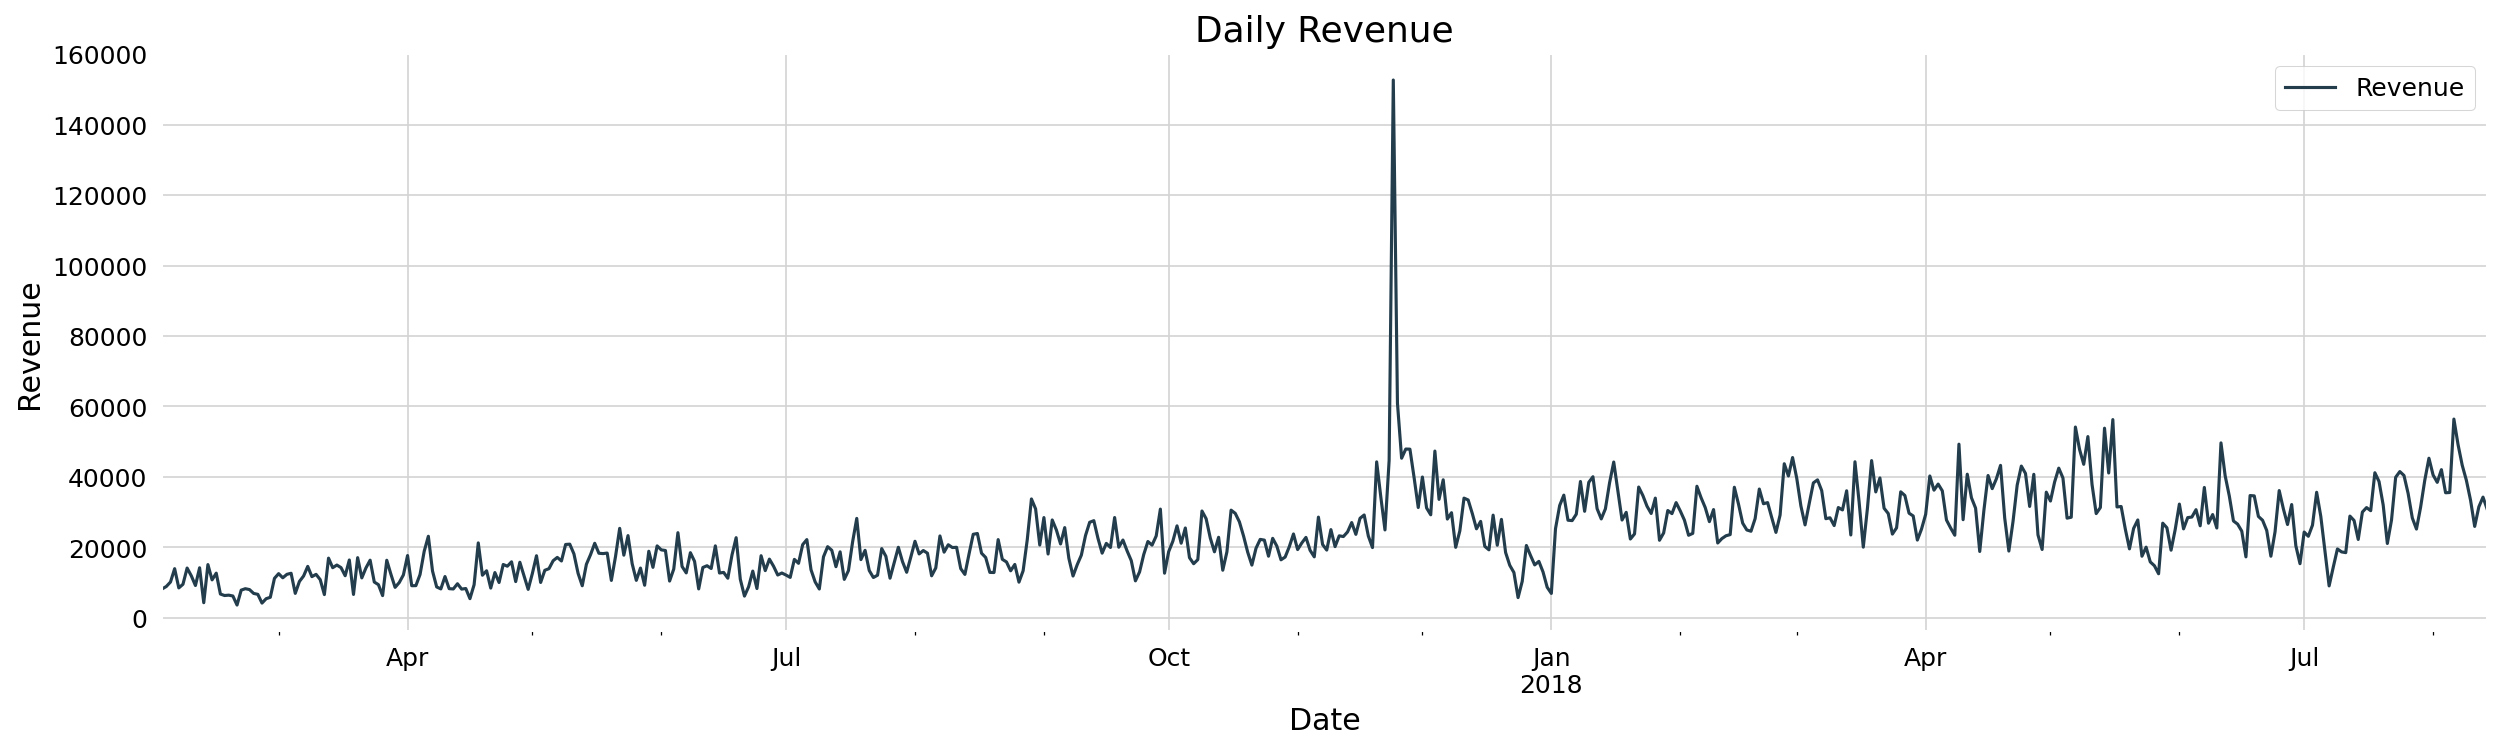

In [9]:
# Creating Figure
fig = df_revenue.plot()

# Customizing 
fig.legend(['Revenue'])
set_image(fig, 'Daily Revenue', 'Date', 'Revenue')

### 2.2. Different types of time analysis

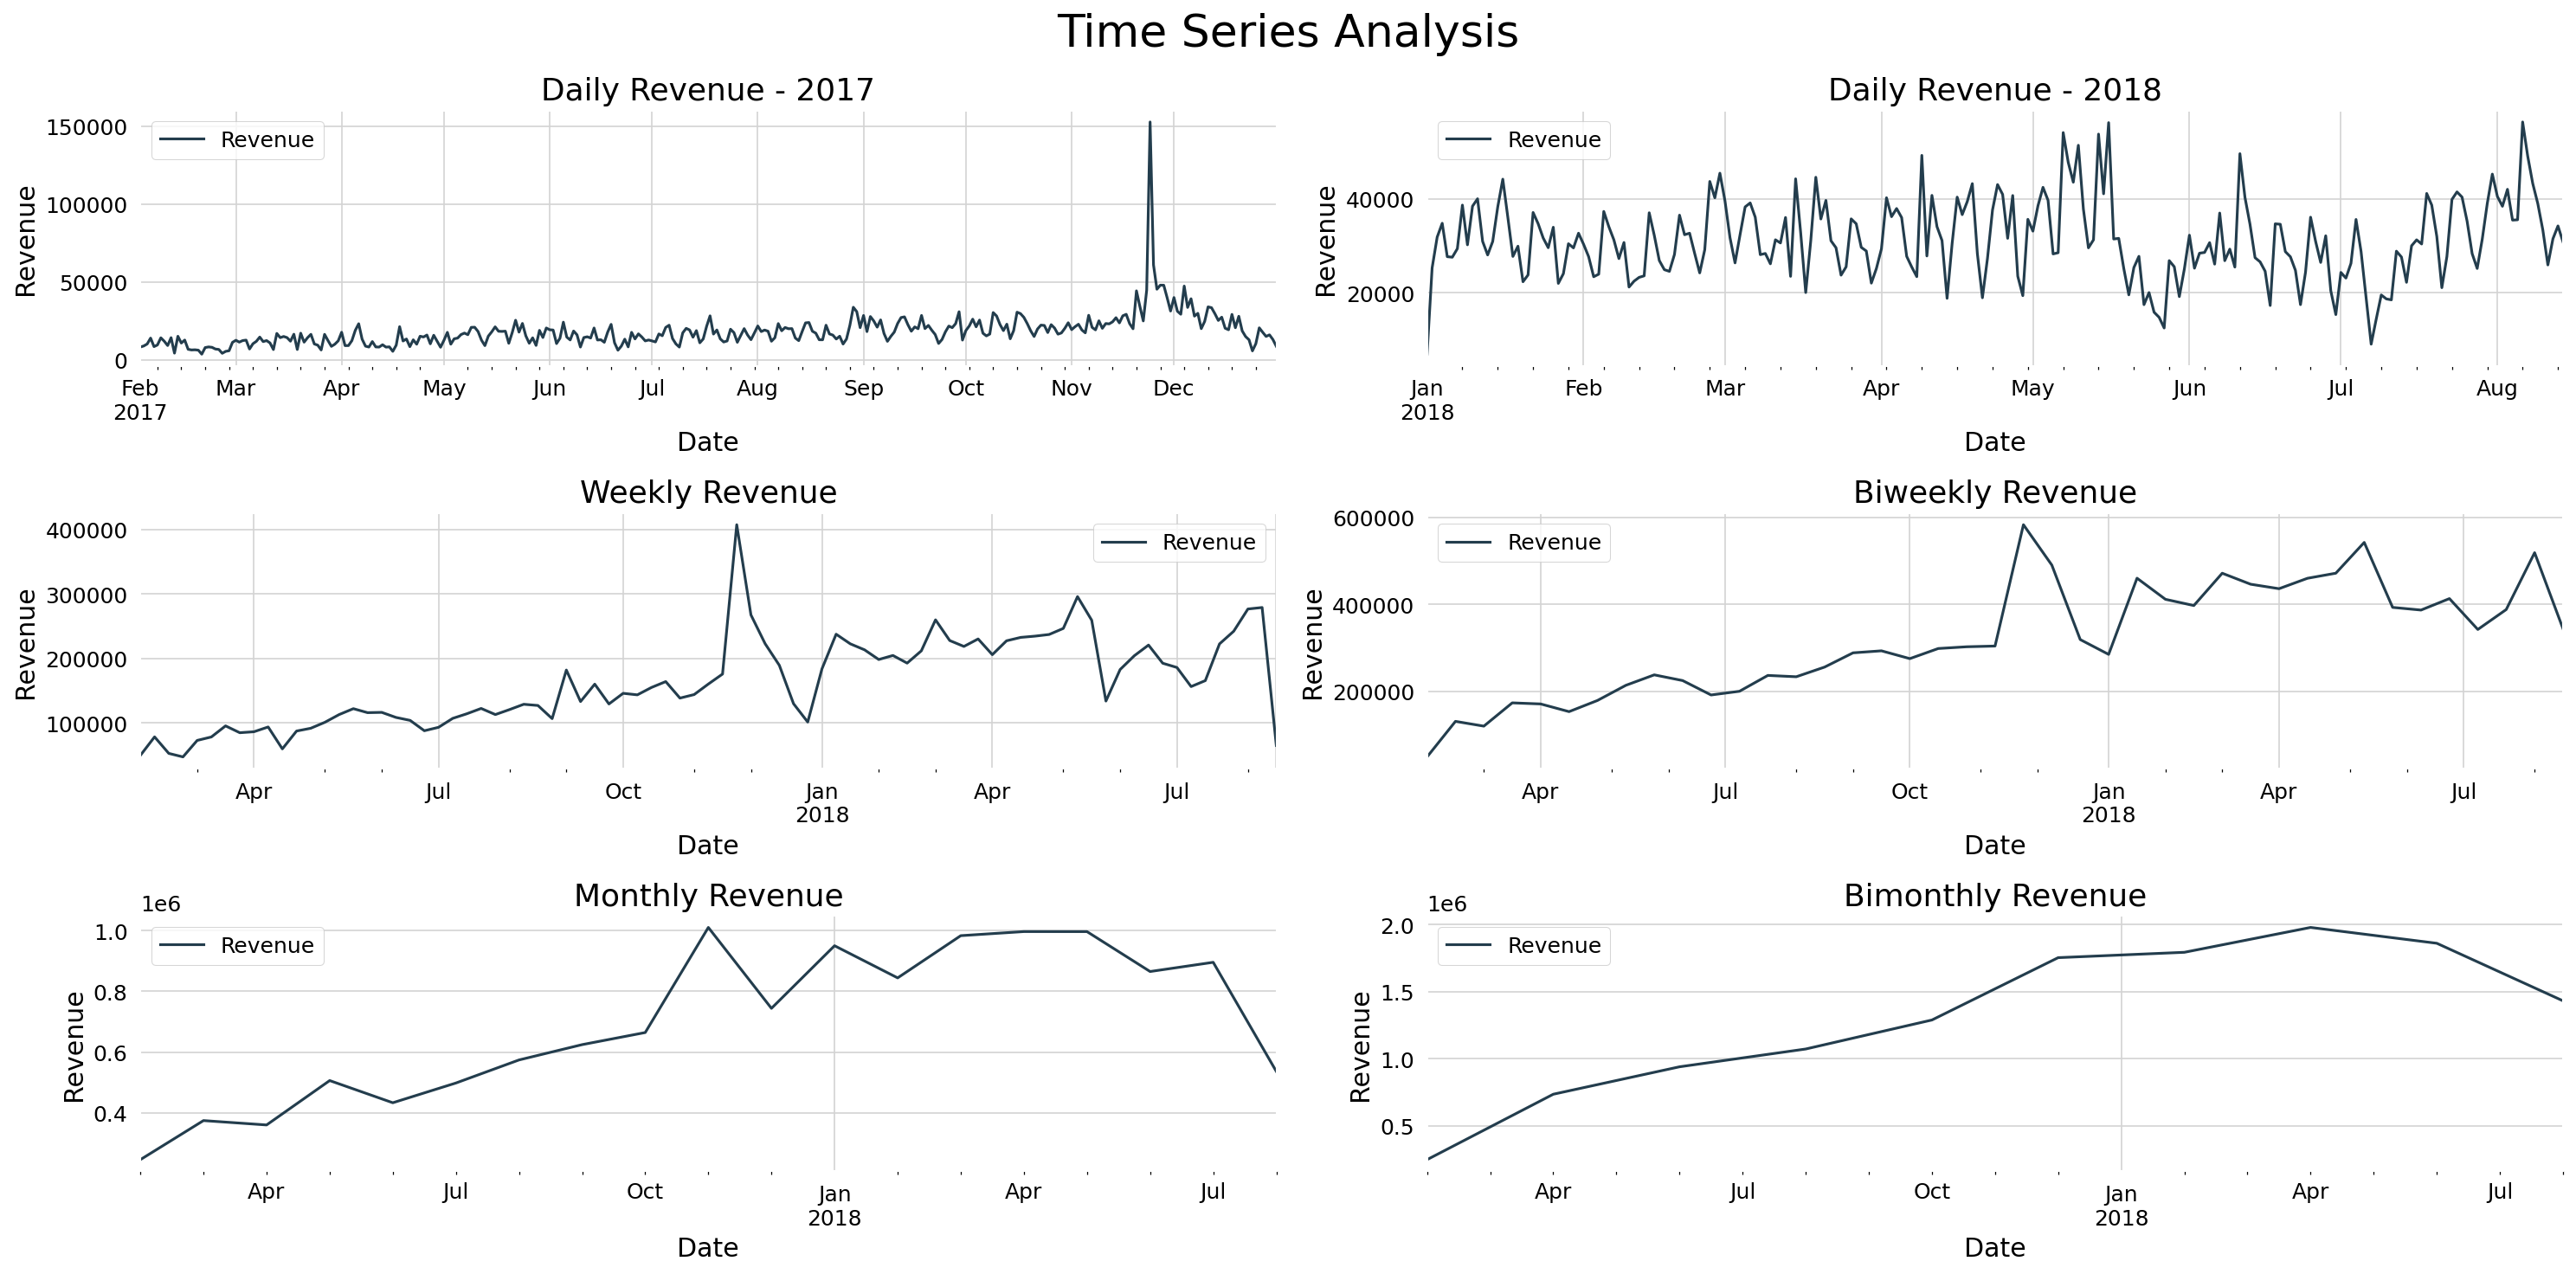

In [10]:
# Creating Figure
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.flatten()

# Plot 1
ax1 = axes[0]
df_revenue['2017'].plot(ax=ax1)
ax1.legend(['Revenue'])
set_image(ax1, 'Daily Revenue - 2017', 'Date', 'Revenue')

# Plot 2
ax2 = axes[1]
df_revenue['2018'].plot(ax=ax2)
ax2.legend(['Revenue'])
set_image(ax2, 'Daily Revenue - 2018', 'Date', 'Revenue')

# Plot 3
ax3 = axes[2]
df_revenue.resample('W').sum().plot(ax=ax3)
ax3.legend(['Revenue'])
set_image(ax3, 'Weekly Revenue', 'Date', 'Revenue')

# Plot 4
ax4 = axes[3]
df_revenue.resample('2W').sum().plot(ax=ax4)
ax4.legend(['Revenue'])
set_image(ax4, 'Biweekly Revenue', 'Date', 'Revenue')

# Plot 5
ax5 = axes[4]
df_revenue.resample('M').sum().plot(ax=ax5)
ax5.legend(['Revenue'])
set_image(ax5, 'Monthly Revenue', 'Date', 'Revenue')

# Plot 6
ax6 = axes[5]
df_revenue.resample('2M').sum().plot(ax=ax6)
ax6.legend(['Revenue'])
set_image(ax6, 'Bimonthly Revenue', 'Date', 'Revenue')

# Main title
plt.suptitle('Time Series Analysis')

# Adjust spacing between subplots
plt.tight_layout()

### 2.3. Exploring a 10-day Rolling Mean *vs.* Original Data

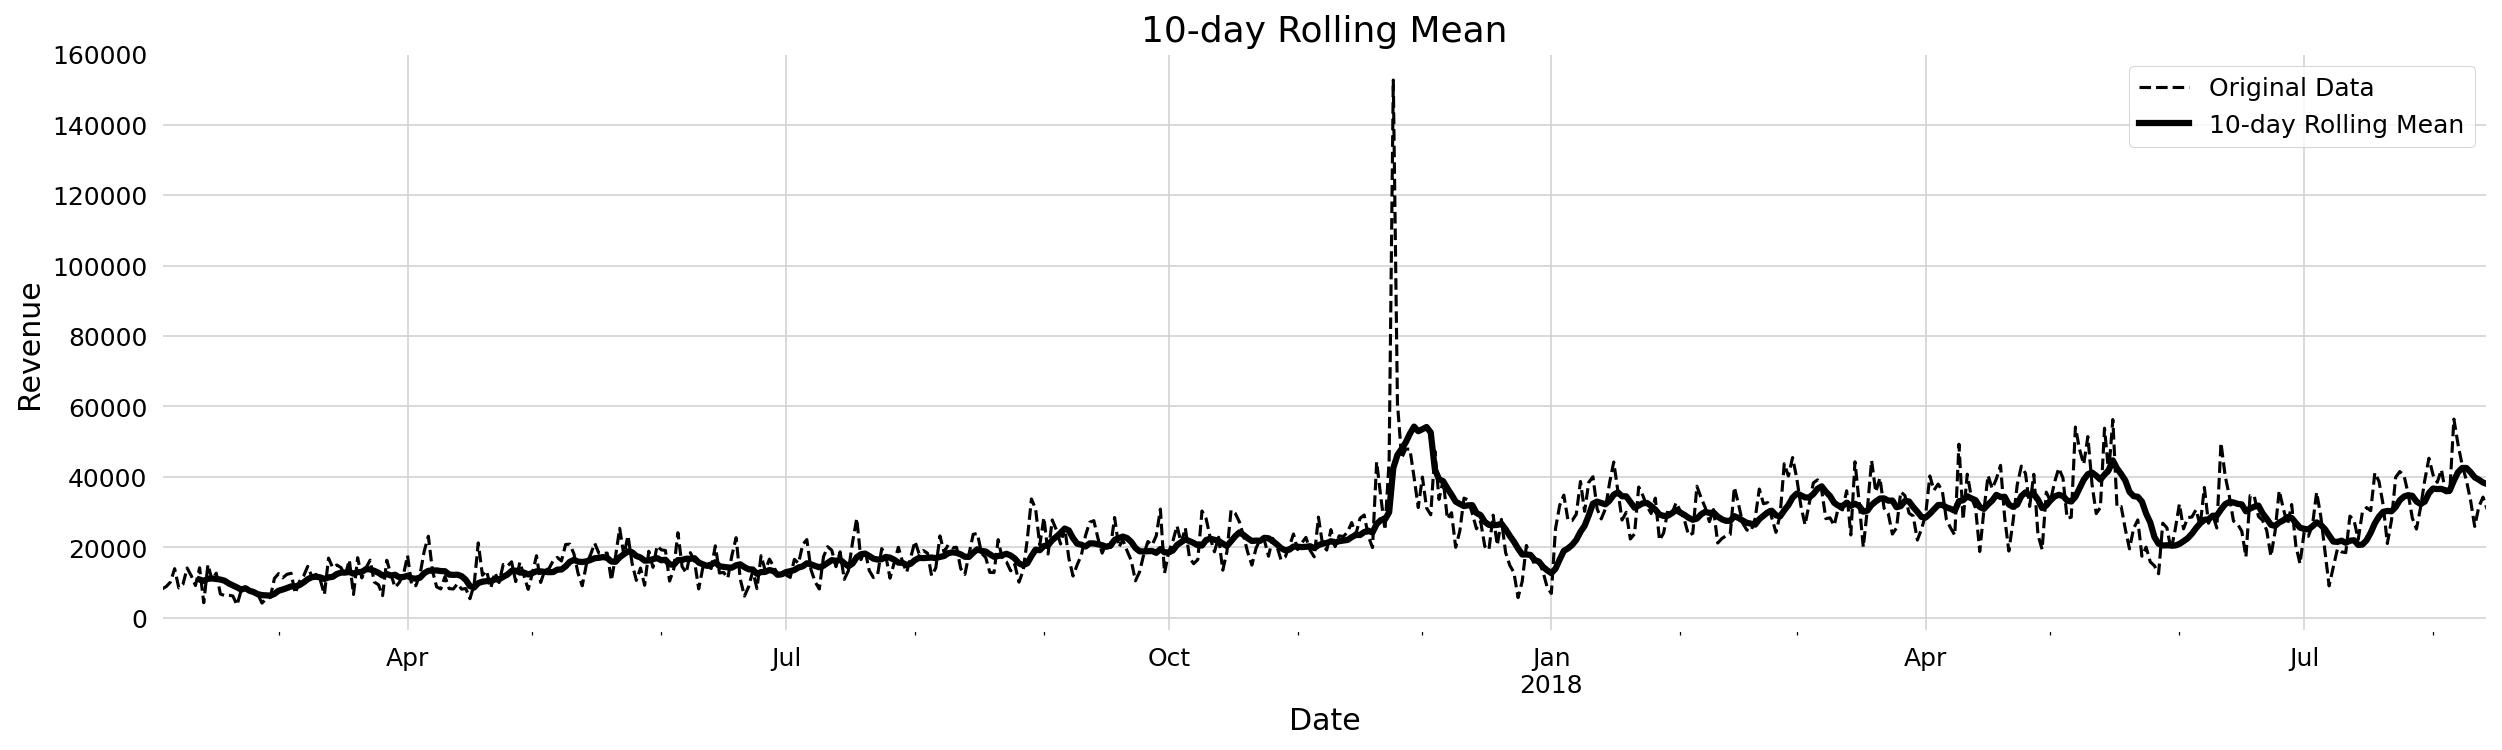

In [11]:
# Applying rolling mean of 10 days
rolling_mean = df_revenue.rolling(10).mean()

# Creating a plot
ax = df_revenue.plot(style='k--')
rolling_mean.plot(style='k-', linewidth=3, ax=ax)

# Customizing the plot
ax.legend(['Original Data', '10-day Rolling Mean'])
ax = set_image(ax, '10-day Rolling Mean', 'Date', 'Revenue')

### 2.4. Visualizing Original Data *vs.* Differenciated Data

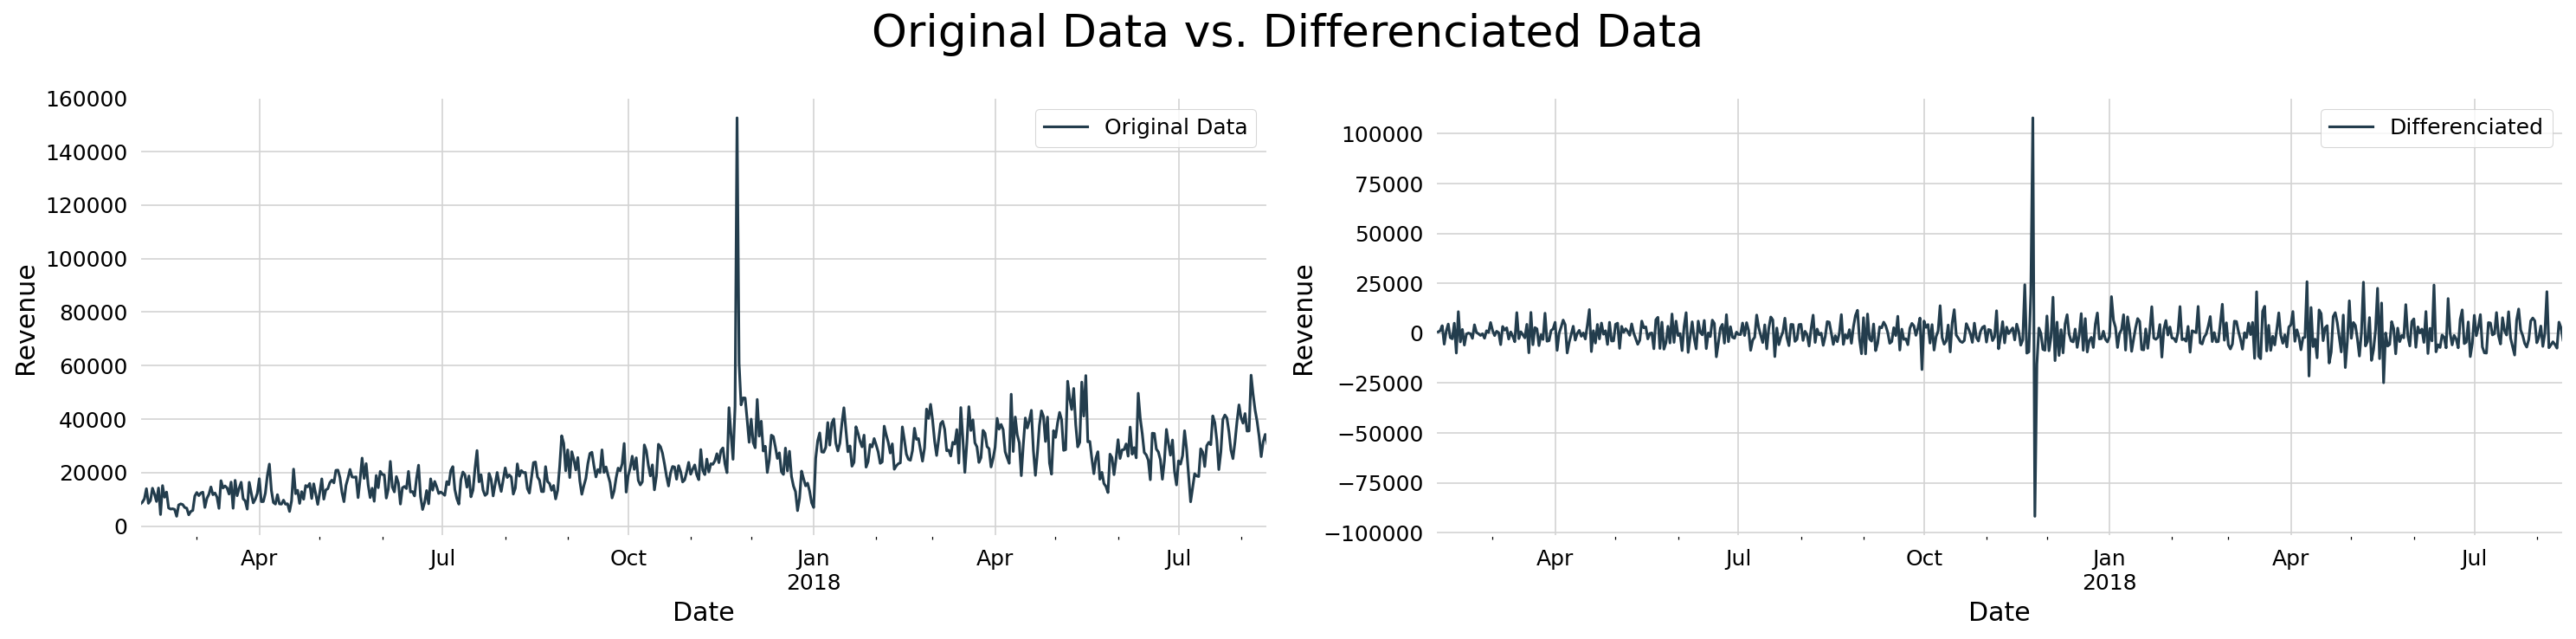

In [12]:
# Creating Figure
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.flatten()

# Plot 1
ax1 = axes[0]
df_revenue.plot(ax=ax1)

# Customizing the plot
ax1.legend(['Original Data'])
set_image(ax1, None, 'Date', 'Revenue')

# Plot 2
ax2 = axes[1]
df_revenue.diff().plot(ax=ax2)

# Customizing the plot
ax2.legend(['Differenciated'])
set_image(ax2, None, 'Date', 'Revenue')

# Main title
plt.suptitle('Original Data vs. Differenciated Data')

# Adjusting spacing between subplots
plt.tight_layout()

## 3. Analysis

Hold-out on the last 2 weeks of the dataset, data that will be forecasted.

In [13]:
df_train = df_revenue['2017-02-01':'2018-07-31']
df_test  = df_revenue['2018-08-01':'2018-08-14']

### 3.1. Descriptive statistics

In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,546.000,23013.057,11789.641,3648.100,14545.538,21222.930,29598.173,152653.740


- There are 546 observations in the dataset
- The **mean** is R$ 23,013.06
- The **standard deviation** is R$ 11,789.64 (almost half of the mean)
- The **minimum** is R$ 3,648.10
- The **median** is R$ 21,222.93 (the median is slightly lower than the mean, so the data is **right-skewed**)
- The 75th percentile is R$ 29,598.17
- The **maximum** is R$ 152,653.74 (more than 5 times the 75h percentile)

### 3.2. Decomposing the time series

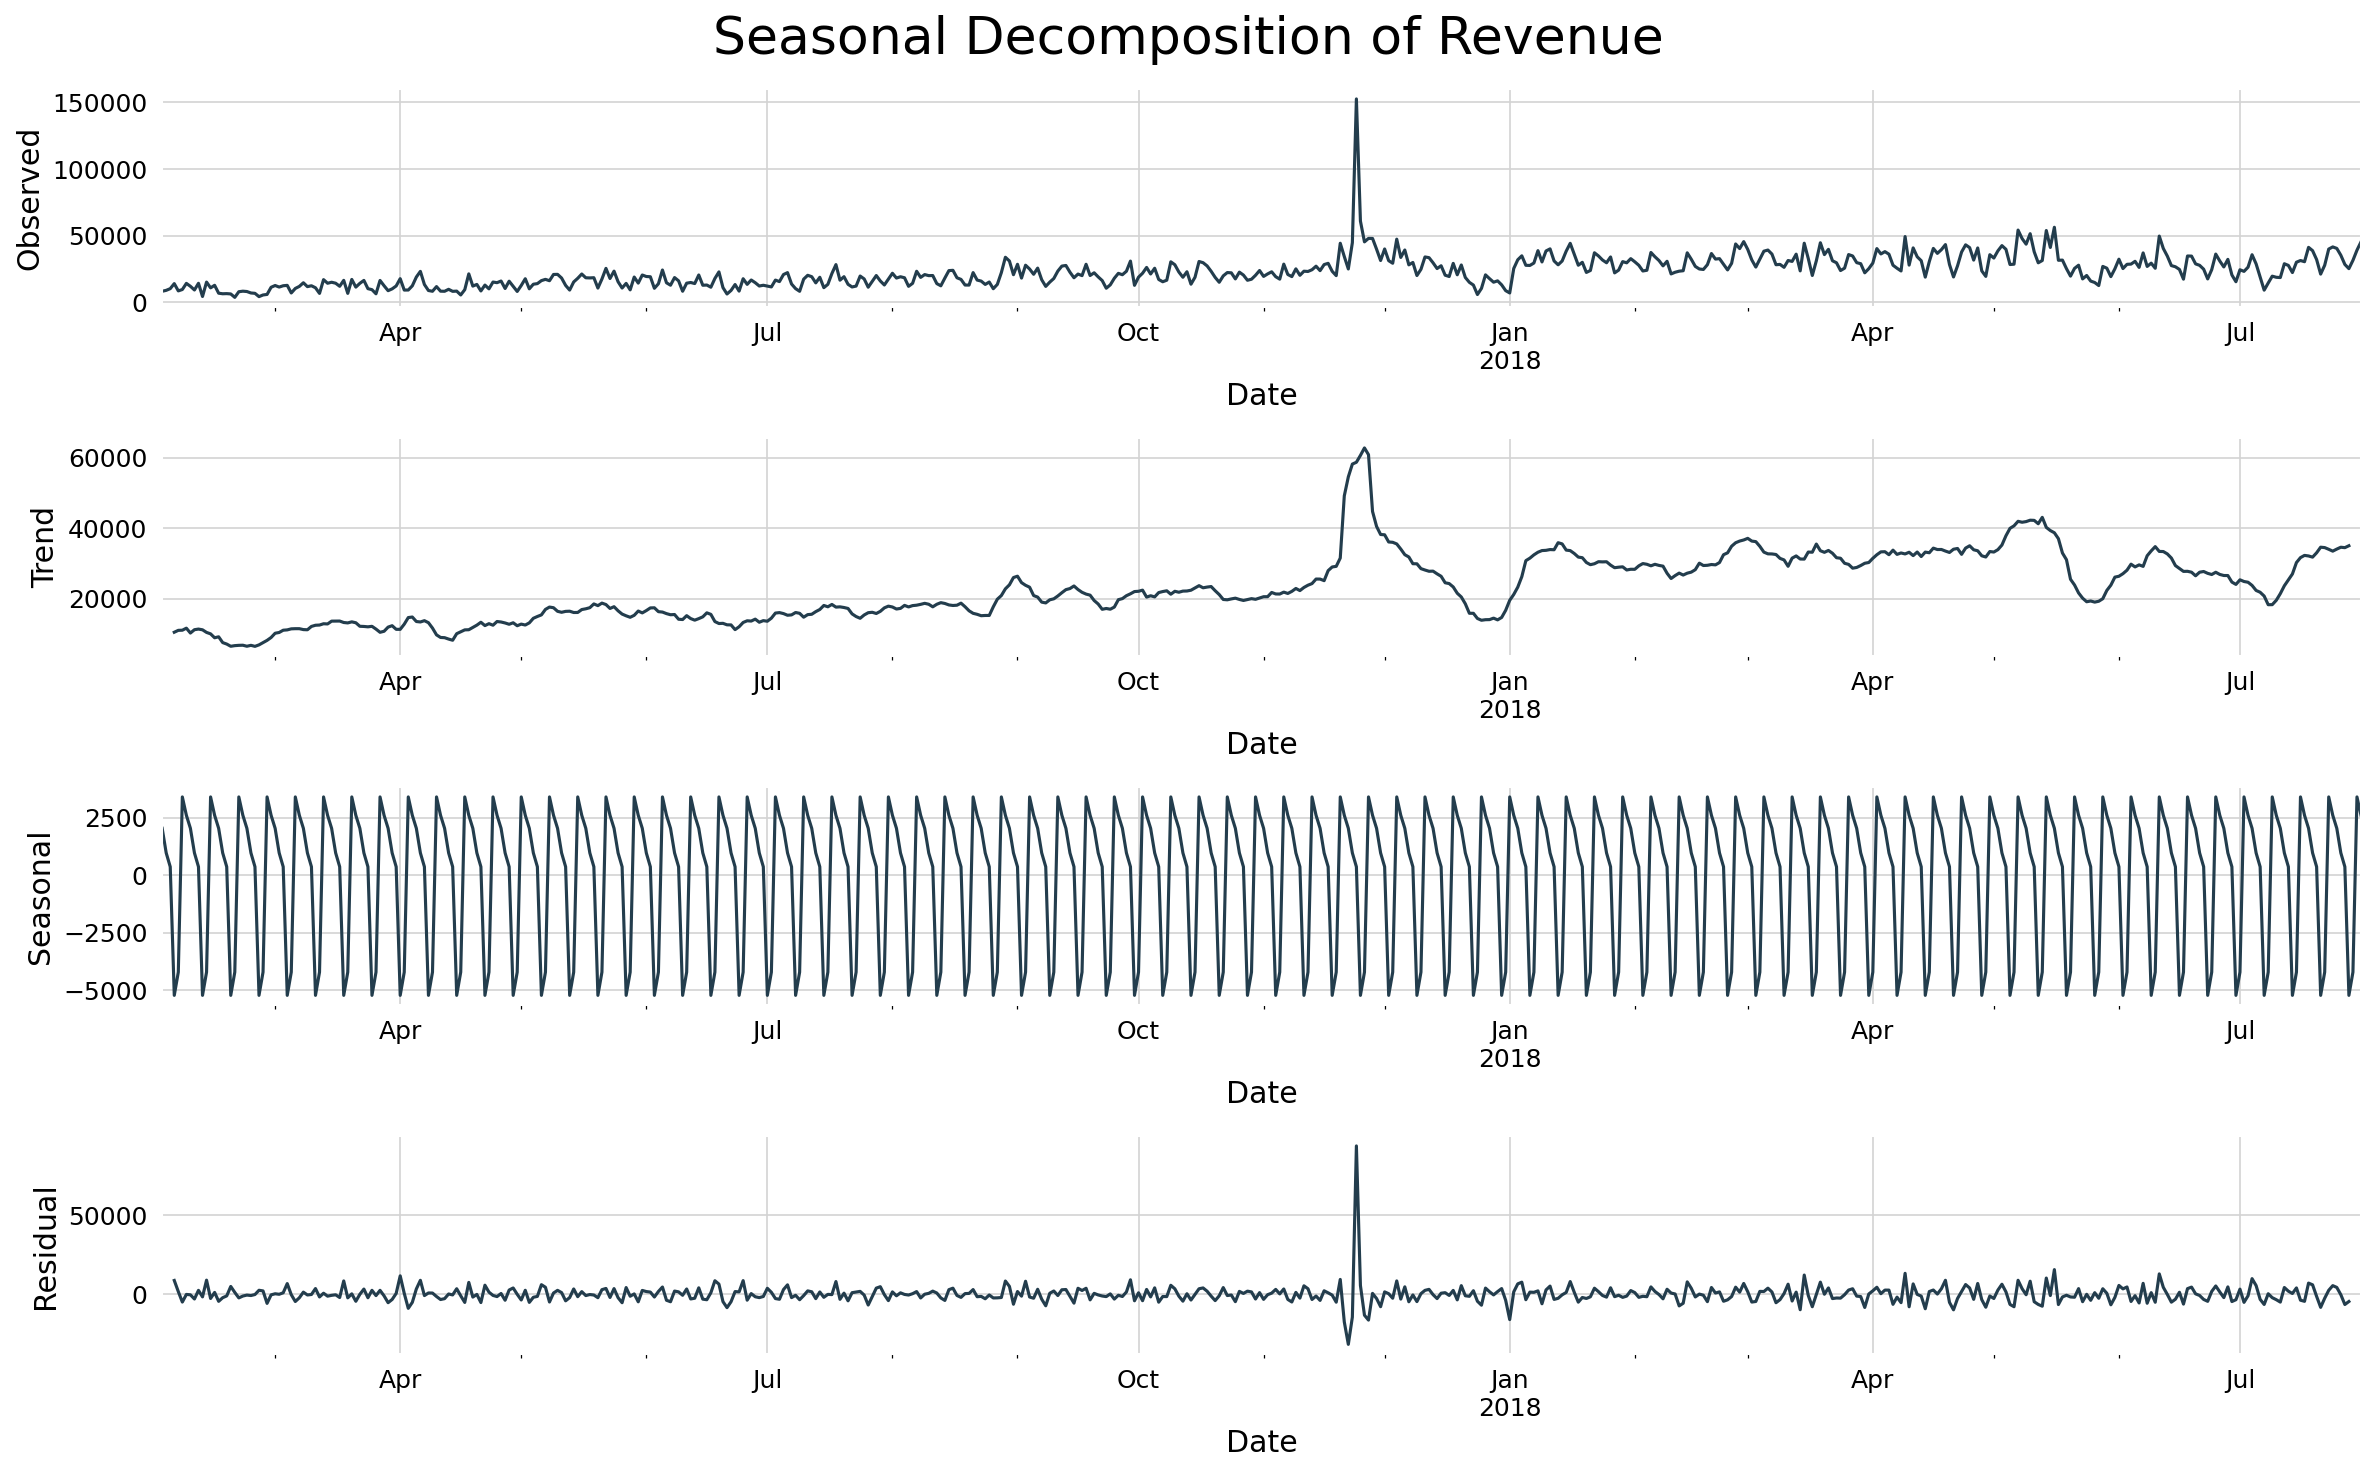

In [15]:
# Decompose
DecomposeResult = seasonal_decompose(
    df_train, 
    model='additive')

# additive decomposition assumes that the effect of the seasonal component is constant across all levels of the time series

# Create a figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10))

# Observed data 
DecomposeResult.observed.plot(ax=ax1)
set_image(ax1, None, 'Date', 'Observed')

# Trend is the long-term (tendency) component of the time series 
DecomposeResult.trend.plot(ax=ax2)
set_image(ax2, None, 'Date', 'Trend')

# Seasonal is the short-term (repeating and cyclical) component of the time series
DecomposeResult.seasonal.plot(ax=ax3)
set_image(ax3, None, 'Date', 'Seasonal')

# Residual is the remainder (error) of the time series after subtracting the trend and seasonal components from the original time series
DecomposeResult.resid.plot(ax=ax4)
set_image(ax4, None, 'Date', 'Residual')

# Main title
plt.suptitle('Seasonal Decomposition of Revenue')

# Adjust layout
plt.tight_layout()

### 3.3. Autocorrelation and Partial Autocorrelation Plots

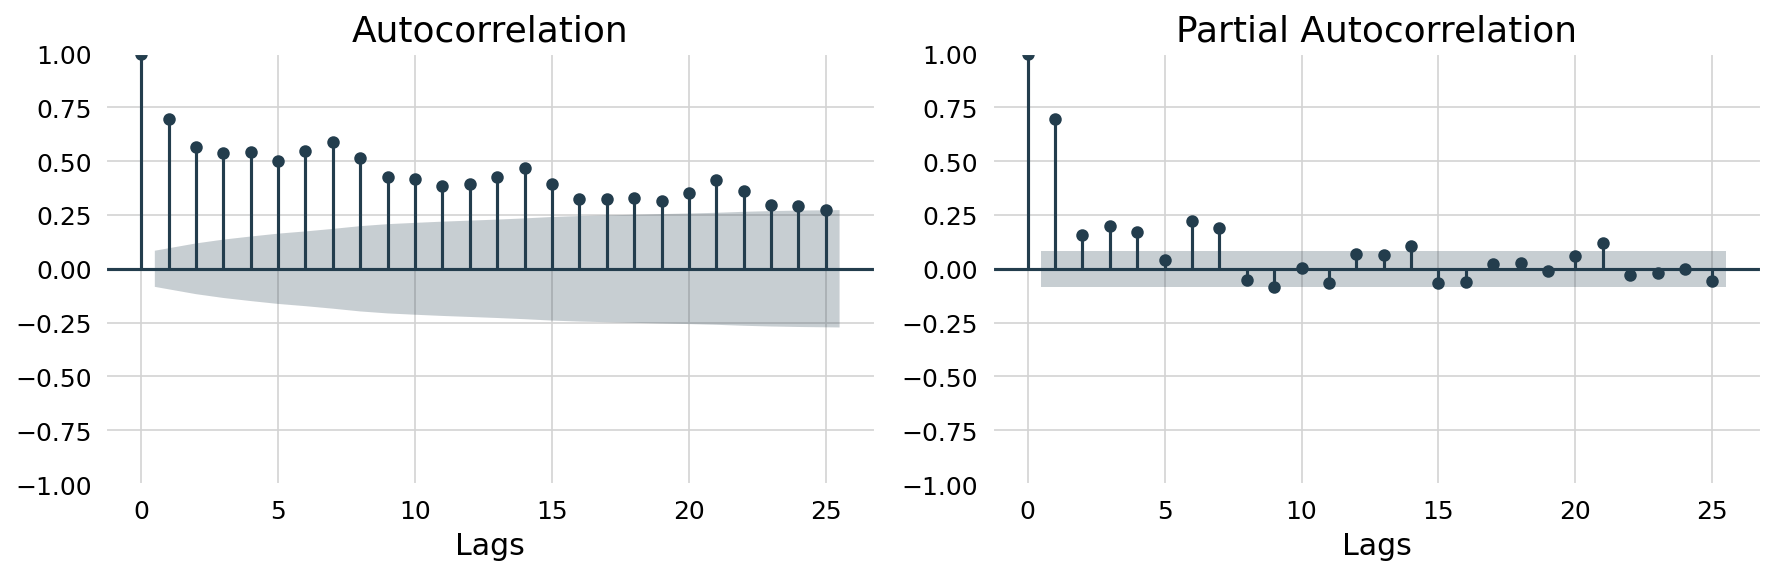

In [16]:
# Creating Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(df_train, lags=25, alpha=0.05, ax=ax1)
set_image(ax1, 'Autocorrelation', 'Lags', None)

# PACF
plot_pacf(df_train, lags=25, alpha=0.05, ax=ax2)
set_image(ax2, 'Partial Autocorrelation', 'Lags', None)
# alpha is the significance level for the confidence intervals

# Adjust layout
plt.tight_layout()

- Autocorrelation plot shows that the 7th, 14th, and 21st lags are higher than the ones around them, indicating a weekly pattern

### 3.4. Stationarity tests (ADF and KPSS)

#### 3.4.1. Augmented Dickey Fuller (ADF)
- The Augmented Dickey-Fuller (ADF) evaluates the null hypothesis that a unit root is present in the time series
- Unit root is present in a time series that is not stationary
- The more negative the statistic, the stronger the evidence against the null hypothesis (non-stationarity)
- If the p-value is less than 0.05, we reject the null hypothesis and conclude that the time series is stationary

In [17]:
# Augmented Dickey-Fuller test on the original data
result = adfuller(df_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.8259773804546313
p-value: 0.05465782398238138


In [18]:
# ADF test on the differenciated data
result = adfuller(df_train.diff().dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.784723007583381
p-value: 8.237850556477621e-12


#### 3.4.2. Kolmogorov-Smirnov (KPSS)
- KPSS is used to test for stationarity and assumes that the data has a deterministic trend
- The KPSS test evaluates the null hypothesis that the time series is trend stationary
- Trend stationary is when the p-value is greater than 0.05
- If the p-value is less than 0.05, we reject the null hypothesis and conclude that the time series is not trend stationary

In [19]:
# KPSS test on original data
result = kpss(df_train)
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

KPSS Statistic: 2.650258381404954
p-value: 0.01


- *p-value* equals to 0.01 is less than the significance level of 0.05
- Therefore, the null hypothesis is rejected
- The decision is to reject the hypothesis that the time series is stationary around a deterministic trend
- This suggests that there is evidence of non-stationarity in your time series data according to the KPSS test

In [20]:
# KPSS test on differenciated data
result = kpss(df_train.diff().dropna())
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

KPSS Statistic: 0.03236838154976303
p-value: 0.1


## 4. Auto ARIMA Model

In [21]:
fit_arima = auto_arima(
    df_train,                       # dataset
    max_p=3,                        # limiting the number of autoregressive terms so the model don't overfit
    max_q=3,                        # limiting the number of moving average terms so the model don't overfit
    m=7,                            # number of periods in the seasonal cycle
    seasonal=True,                  # try for seasonal data
    seasonal_test='ocsb',           # use the OCSB test
    d=1,                            # number of differencing equals to 1 because of ADF and KPSS results
    trace=False,                    # to don't print the progress of the model
    information_criterion='bic',    # choose the best model based on Bayesian information criterion
    stepwise=False                  # testing all possible combinations
)

### 4.1. Summary

In [22]:
# Print the summary of the best model
print(fit_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  546
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -5639.536
Date:                           Tue, 02 Jan 2024   AIC                          11289.071
Time:                                   11:32:41   BIC                          11310.575
Sample:                               02-01-2017   HQIC                         11297.478
                                    - 07-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -10.0156     14.312     -0.700      0.484     -38.066      18.035
ma.L1         -0.6211      0.021    -29.240

### 4.2. Forecast

In [23]:
# Forecast future values 
test_forecast, conf_int = fit_arima.predict(n_periods=14, return_conf_int=True)

In [24]:
# Predicted values on the next 14 days
test_forecast

2018-08-01   40111.447
2018-08-02   39464.557
2018-08-03   35809.848
2018-08-04   30519.060
2018-08-05   33032.159
2018-08-06   41050.511
2018-08-07   40163.538
2018-08-08   39914.021
2018-08-09   39268.342
2018-08-10   35667.038
2018-08-11   30458.048
2018-08-12   32917.520
2018-08-13   40786.711
2018-08-14   39905.114
Freq: D, dtype: float64

In [25]:
# Confidence interval
conf_int

array([[24840.89708384, 55381.99658642],
       [23134.40253793, 55794.71205436],
       [18484.77264356, 53134.9223776 ],
       [12253.17728102, 48784.94339592],
       [13871.60699656, 52192.71076924],
       [21035.24167979, 61065.78068739],
       [19328.58423961, 60998.49080883],
       [17946.28336028, 61881.75862595],
       [16433.61562323, 62103.06745868],
       [11997.05833731, 59337.01688271],
       [ 5981.30100558, 54934.79443772],
       [ 7659.76193022, 58175.2779955 ],
       [14771.37833144, 66802.04436093],
       [13153.65120705, 66656.57686943]])

### 4.3. Evaluating metrics

In [26]:
# Transforming the dataframes to numpy array
y_true = np.array(df_test)
y_pred = np.array(test_forecast)

# Creating metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 4783.969017717254
Root Mean Squared Error (RMSE): 6284.0165495765505
Mean Absolute Percentage Error (MAPE): 17.10824494692397


### 4.4. Visualizing the forecast

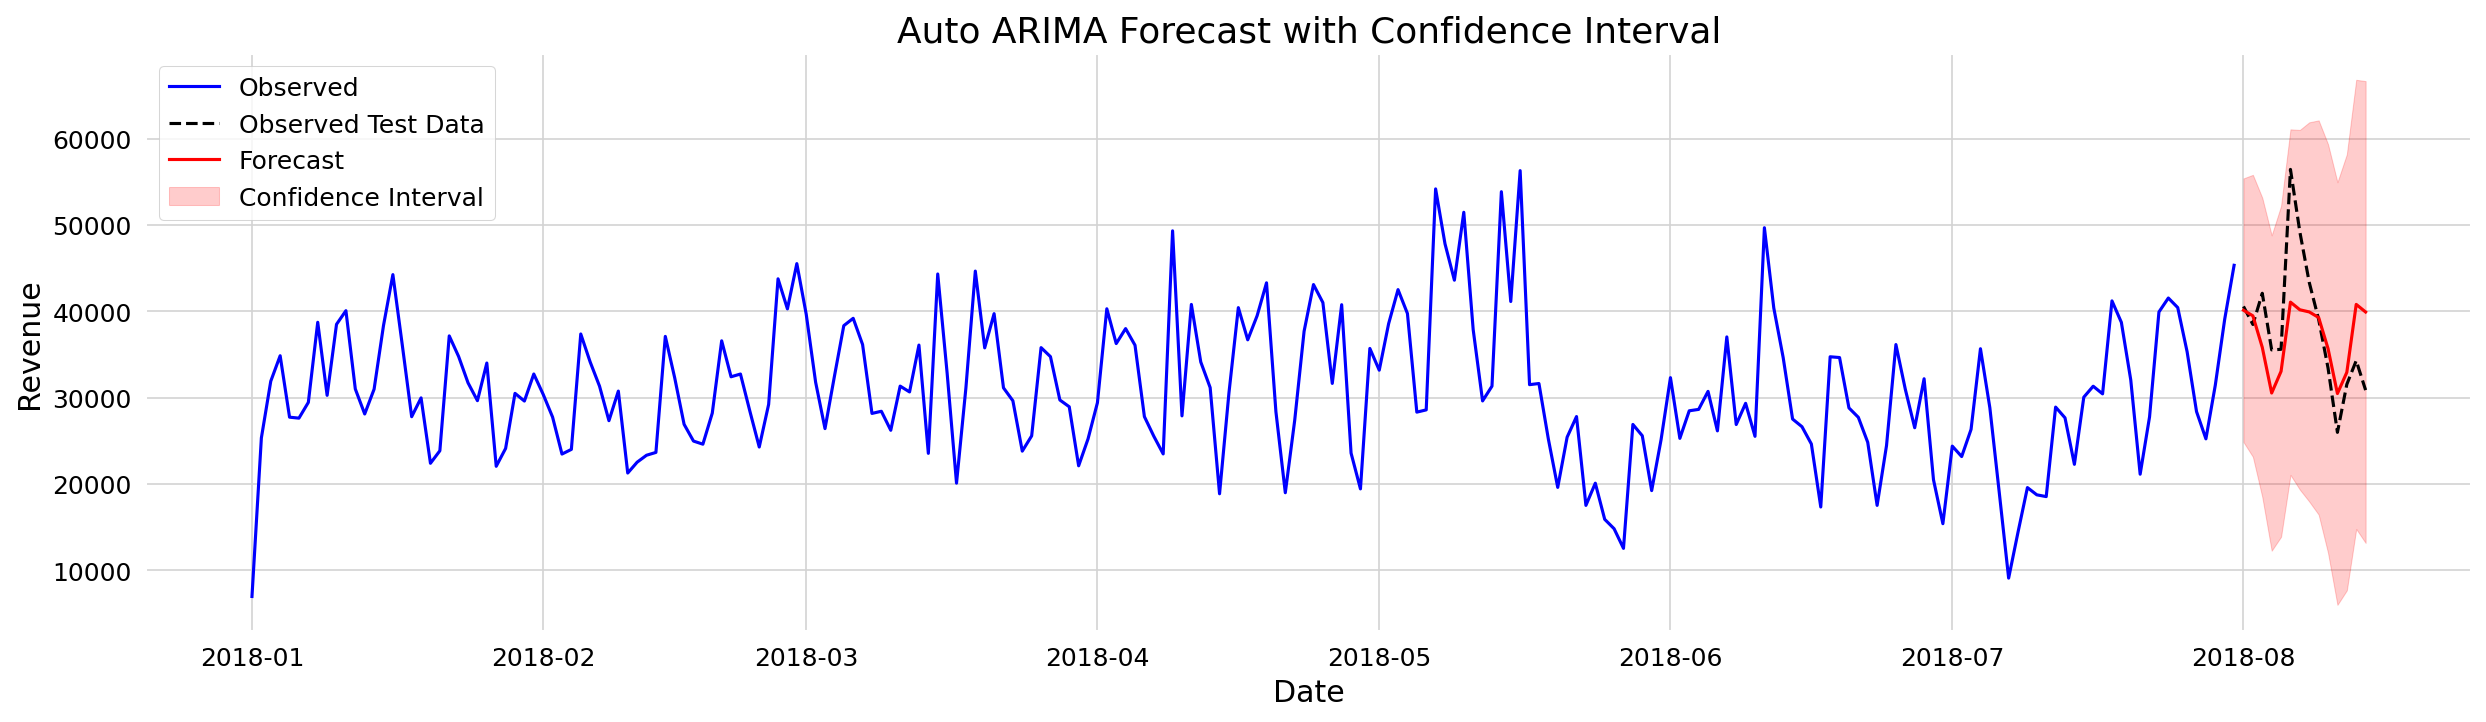

In [27]:
# Create Figure
fig, ax = plt.subplots()

# Time series data
ax.plot(df_train['2018'], label='Observed', color='blue')
ax.plot(df_test.index, df_test, label='Observed Test Data', color='black', linestyle='--')

# Forecast
ax.plot(df_test.index, test_forecast, color='red', label='Forecast')

# Confidence interval
ax.fill_between(df_test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2, label='Confidence Interval')

# Display the legend
ax.legend()

# Customizing 
set_image(ax, 'Auto ARIMA Forecast with Confidence Interval', 'Date', 'Revenue')

***

## 5. ARIMA Model

In [28]:
# Modeling
model = ARIMA(df_train, order=(3, 1, 1))
# Fitting
results = model.fit()

### 5.1. Summary

In [29]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  546
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -5666.163
Date:                Tue, 02 Jan 2024   AIC                          11342.326
Time:                        11:32:43   BIC                          11363.830
Sample:                    02-01-2017   HQIC                         11350.733
                         - 07-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3066      0.059      5.198      0.000       0.191       0.422
ar.L2         -0.0889      0.056     -1.578      0.115      -0.199       0.022
ar.L3         -0.0087      0.066     -0.132      0.8

### 5.2. Forecast

In [30]:
forecast = results.get_forecast(steps=14)

In [31]:
forecast_values = forecast.predicted_mean
forecast_values

2018-08-01   38344.823
2018-08-02   35585.983
2018-08-03   35305.639
2018-08-04   35525.617
2018-08-05   35641.982
2018-08-06   35660.538
2018-08-07   35653.968
2018-08-08   35649.292
2018-08-09   35648.281
2018-08-10   35648.444
2018-08-11   35648.624
2018-08-12   35648.674
2018-08-13   35648.672
2018-08-14   35648.665
Freq: D, Name: predicted_mean, dtype: float64

In [32]:
conf_int = forecast.conf_int()
conf_int

,lower revenue,upper revenue
2018-08-01,22256.969,54432.677
2018-08-02,17712.894,53459.072
2018-08-03,17030.692,53580.586
2018-08-04,16974.213,54077.021
2018-08-05,16776.859,54507.104
2018-08-06,16457.237,54863.839
2018-08-07,16112.047,55195.889
2018-08-08,15775.610,55522.974
2018-08-09,15449.408,55847.153
2018-08-10,15129.831,56167.057


### 5.3. Evaluating metrics

In [33]:
# Transforming the dataframes to numpy array
y_true = np.array(df_test)
y_pred = np.array(forecast_values)

# Creating metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 5679.345252217668
Root Mean Squared Error (RMSE): 7948.31068114175
Mean Absolute Percentage Error (MAPE): 14.552690179393988


### 5.4. Visualizing the forecast

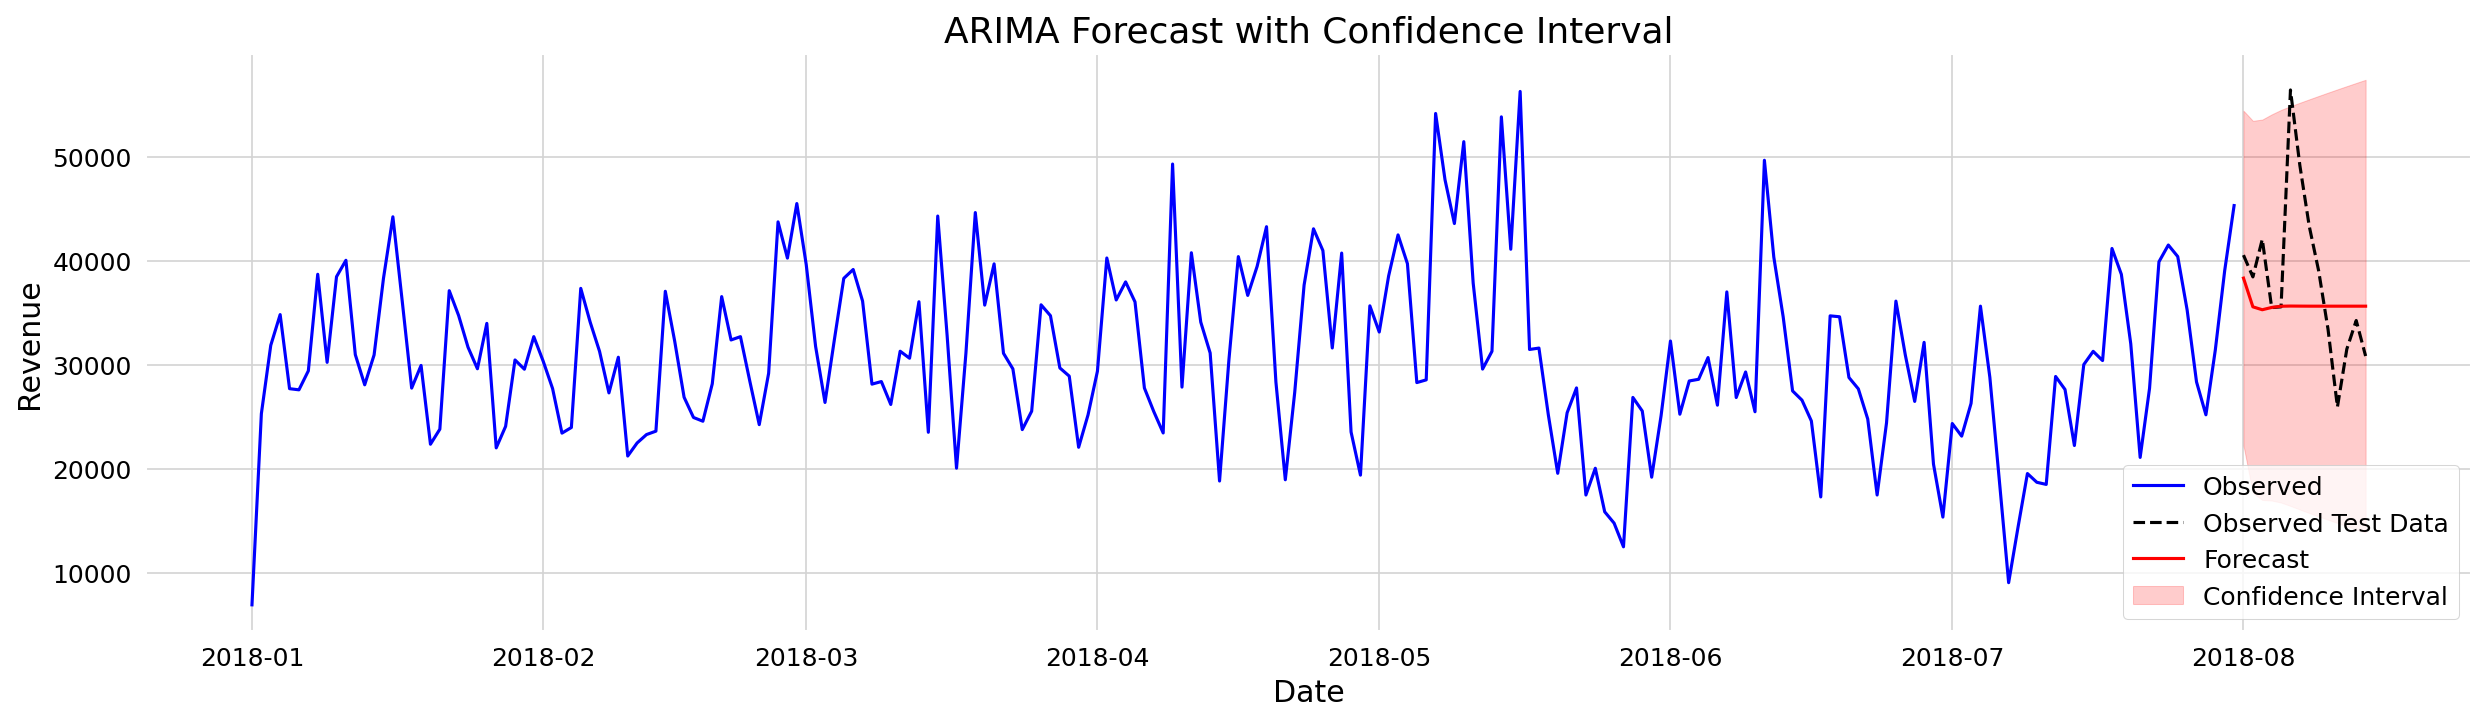

In [34]:
# Create Figure
fig, ax = plt.subplots()

# Time series data
ax.plot(df_train['2018'], label='Observed', color='blue')
ax.plot(df_test.index, df_test, label='Observed Test Data', color='black', linestyle='--')

# Forecast
ax.plot(df_test.index, forecast_values, color='red', label='Forecast')

# Confidence interval
ax.fill_between(df_test.index, conf_int['lower revenue'], conf_int['upper revenue'], color='red', alpha=0.2, label='Confidence Interval')

# Display the legend
ax.legend()

# Customizing 
set_image(ax, 'ARIMA Forecast with Confidence Interval', 'Date', 'Revenue')

- The AIC and BIC values are lower than the Auto ARIMA model
- MAE and RMSE are slightly **higher** than the Auto ARIMA model
- MAPE is slightly **lower** than the Auto ARIMA model, indicating better results
- However, the ARIMA model was unable to capture the movements of the time series data, predicting only the trend of it

***

## 6. SARIMA Model

In [35]:
# Fit the same orders from Auto ARIMA to compare the models
model   = SARIMAX(df_train, order=(3, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit()

### 6.1. Summary

In [36]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                  546
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5603.093
Date:                           Tue, 02 Jan 2024   AIC                          11218.186
Time:                                   11:32:45   BIC                          11243.913
Sample:                               02-01-2017   HQIC                         11228.249
                                    - 07-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4225      0.046      9.209      0.000       0.333       0.512
ar.L2          0.0847      0.077      1.101

### 6.2. Forecast

In [37]:
forecast = results.get_forecast(steps=14)

In [39]:
forecast_values = forecast.predicted_mean
forecast_values

2018-08-01   40056.656
2018-08-02   37318.855
2018-08-03   33181.837
2018-08-04   25743.480
2018-08-05   27967.279
2018-08-06   37552.933
2018-08-07   36077.305
2018-08-08   35592.457
2018-08-09   34482.295
2018-08-10   30389.993
2018-08-11   23755.981
2018-08-12   26544.132
2018-08-13   36442.386
2018-08-14   35255.708
Freq: D, Name: predicted_mean, dtype: float64

In [40]:
conf_int = forecast.conf_int()
conf_int

,lower revenue,upper revenue
2018-08-01,20239.065,59874.248
2018-08-02,15682.607,58955.103
2018-08-03,10818.280,55545.393
2018-08-04,2556.676,48930.284
2018-08-05,4337.430,51597.127
2018-08-06,13662.277,61443.589
2018-08-07,11997.267,60157.344
2018-08-08,11172.843,60012.071
2018-08-09,9904.701,59059.889
2018-08-10,5708.450,55071.537


### 6.3. Evaluating metrics

In [41]:
# Transforming the dataframes to numpy array
y_true = np.array(df_test)
y_pred = np.array(forecast_values)

# Creating metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 6356.7678252507585
Root Mean Squared Error (RMSE): 8043.2507407408075
Mean Absolute Percentage Error (MAPE): 19.76514496657077


### 6.4. Visualizing the forecast

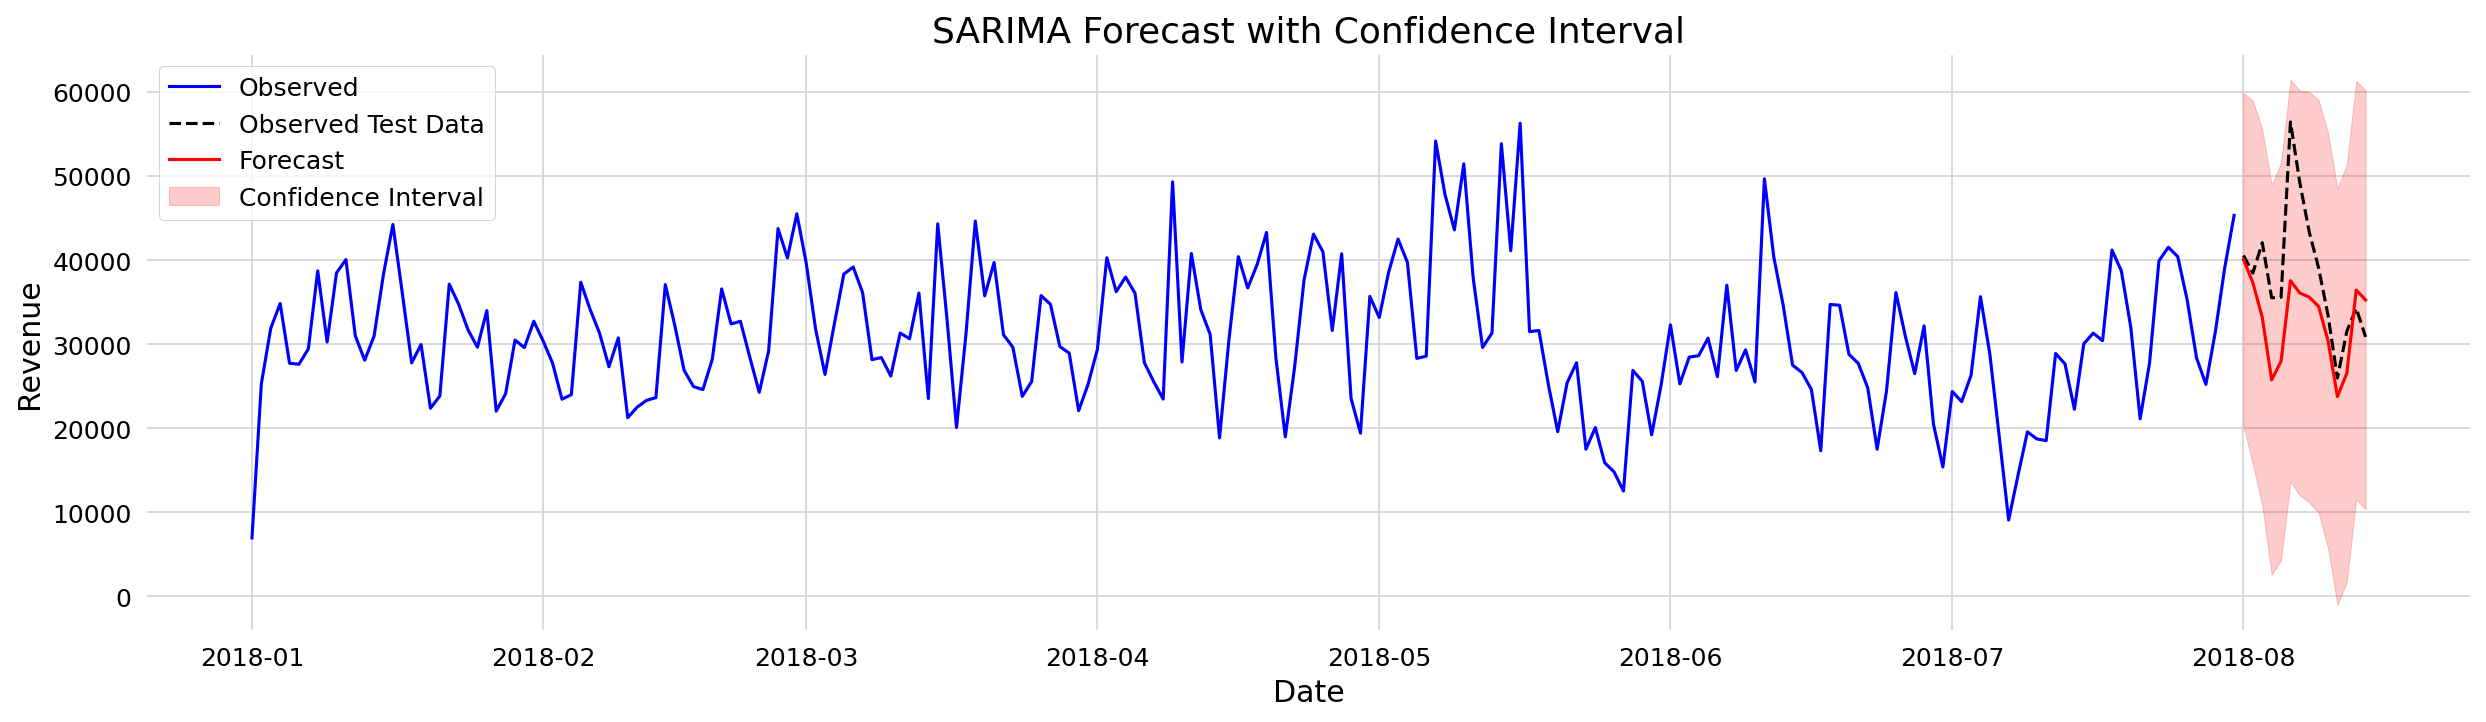

In [42]:
# Create Figure
fig, ax = plt.subplots()

# Time series data
ax.plot(df_train['2018'], label='Observed', color='blue')
ax.plot(df_test.index, df_test, label='Observed Test Data', color='black', linestyle='--')

# Forecast
ax.plot(df_test.index, forecast_values, color='red', label='Forecast')

# Confidence interval
ax.fill_between(df_test.index, conf_int['lower revenue'], conf_int['upper revenue'], color='red', alpha=0.2, label='Confidence Interval')

# Display the legend
ax.legend()

# Customizing 
set_image(ax, 'SARIMA Forecast with Confidence Interval', 'Date', 'Revenue')

- The AIC and BIC criterias are the lowest between the three models used
- Unlike ARIMA, the SARIMA model was able to capture the movements of the time series data due to its Seasonal component
- The SARIMA metrics are a little worse than ARIMA
- Even though, the last few days of the forecast have a great forecast fitting

## 7. Next Steps

- Incorporate other variables and use multivariate time series models like VAR and VECM
- Compare these results with other models, like Gradient Boosting models